<a href="https://colab.research.google.com/github/seoharu/DATA-AI/blob/main/covid19_detection_fasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
def get_train_file_path(image_id):
    return "/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/slim-covid 19-detection/resized_archive/train".format(image_id)

def get_test_file_path(image_id):
    return "/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/slim-covid 19-detection/resized_archive/test".format(image_id)

In [62]:
import pandas as pd

updated_train_labels = pd.read_csv('/content/drive/MyDrive/JBNU/2023 AI 전공특화교육/project/slim-covid 19-detection/updated_train_labels.csv/updated_train_labels.csv')

updated_train_labels['jpg_path'] = updated_train_labels['id'].apply(get_train_file_path)
train = updated_train_labels.copy()
display(train.head())

,id,dcm_path,xmin,ymin,xmax,ymax,human_label,negative,typical,indeterminate,...,ImageInstanceUID,img_shape,width,height,frac_xmin,frac_xmax,frac_ymin,frac_ymax,integer_label,jpg_path
0,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,2245.91208,591.20528,3340.57370,2352.75472,typical,0,1,0,...,000a312787f2,"(3488, 4256)",4256,3488,0.527705,0.784909,0.169497,0.674528,3,/content/drive/MyDrive/JBNU/2023 AI 전공특ᄒ...
1,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,789.28836,582.43035,1815.94498,2499.73327,typical,0,1,0,...,000a312787f2,"(3488, 4256)",4256,3488,0.185453,0.426679,0.166981,0.716667,3,/content/drive/MyDrive/JBNU/2023 AI 전공특ᄒ...
2,000c3a3f293f,/kaggle/input/siim-covid19-detection/train/ff0...,0.00000,0.00000,1.00000,1.00000,negative,1,0,0,...,000c3a3f293f,"(2320, 2832)",2832,2320,0.000000,0.000353,0.000000,0.000431,2,/content/drive/MyDrive/JBNU/2023 AI 전공특ᄒ...
3,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,677.42216,197.97662,1545.21983,1197.75876,typical,0,1,0,...,0012ff7358bc,"(2544, 3056)",3056,2544,0.221670,0.505635,0.077821,0.470817,3,/content/drive/MyDrive/JBNU/2023 AI 전공특ᄒ...
4,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,1792.69064,402.55250,2409.71798,1606.91050,typical,0,1,0,...,0012ff7358bc,"(2544, 3056)",3056,2544,0.586613,0.788520,0.158236,0.631647,3,/content/drive/MyDrive/JBNU/2023 AI 전공특ᄒ...


In [ ]:
# libraries

In [64]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

In [ ]:
# CFG

In [65]:
class DefaultConfig:
    n_folds: int = 5
    seed: int = 2021
    num_classes: int = 4 # "negative", "typical", "indeterminate", "atypical"
    img_size: int = 256
    fold_num: int = 0
    device: str = 'cuda:0'

In [66]:
device = torch.device(DefaultConfig.device) if torch.cuda.is_available() else torch.device('cpu')


In [68]:
## Choose your optimizers:
Adam = False
if Adam:
    Adam_config = {"lr" : 0.001, "betas" : (0.9, 0.999), "eps" : 1e-08}
else:
    SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.001}

In [69]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(DefaultConfig.seed)

In [ ]:
# split

In [70]:
df_folds = train.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=DefaultConfig.seed)
for n, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds.integer_label)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = int(n)
df_folds['fold'] = df_folds['fold'].astype(int)
print(df_folds.groupby(['fold', df_folds.integer_label]).size())

fold  integer_label
0     0                 126
      1                 299
      2                 347
      3                1207
1     0                 126
      1                 299
      2                 347
      3                1207
2     0                 126
      1                 299
      2                 347
      3                1207
3     0                 126
      1                 298
      2                 347
      3                1207
4     0                 125
      1                 299
      2                 348
      3                1206
dtype: int64


In [ ]:
# albumentaion

In [71]:
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                 val_shift_limit=0.2, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2,
                                       contrast_limit=0.2, p=0.3),
        ], p=0.2),
        A.Resize(height=DefaultConfig.img_size, width=DefaultConfig.img_size, p=1.0),
        #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ],
    p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=DefaultConfig.img_size, width=DefaultConfig.img_size, p=1.0),
        #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# dataset & dataloader

In [72]:
class CustomDataset(Dataset):

    def __init__(self, image_ids, df, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.df = df
        self.file_names = df['jpg_path'].values
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image, boxes, labels = self.load_image_and_boxes(index)

        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]


    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(self.file_names[index], cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.df[self.df['id'] == image_id]
        boxes = []
        for bbox in records[['frac_xmin', 'frac_ymin', 'frac_xmax', 'frac_ymax']].values:
            bbox = np.clip(bbox, 0, 1.0)
            temp = A.convert_bbox_from_albumentations(bbox, 'pascal_voc', image.shape[0], image.shape[0])
            boxes.append(temp)
        '''
        [0: 'atypical', 1: 'indeterminate', 2: 'negative', 3: 'typical']
        '''
        labels = records['integer_label'].values
        return image, boxes, labels

In [73]:
df_folds = df_folds.set_index('id')

def get_train_dataset(fold_number):
    return CustomDataset(
        image_ids = df_folds[df_folds['fold'] != fold_number].index.values,
        df = train,
        transforms = get_train_transforms()
    )

def get_validation_dataset(fold_number):
    return CustomDataset(
        image_ids = df_folds[df_folds['fold'] == fold_number].index.values,
        df = train,
        transforms = get_valid_transforms()
    )

def get_train_data_loader(train_dataset, batch_size=16):
    return DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4,
        collate_fn = collate_fn
    )

def get_validation_data_loader(valid_dataset, batch_size=16):
    return DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4,
        collate_fn = collate_fn
    )

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# show one image

In [74]:
try:
    train_dataset = get_train_dataset(0)
    image, target, image_id = train_dataset[2]
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    numpy_image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in boxes:
        cv2.rectangle(numpy_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    ax.set_axis_off()
    ax.imshow(numpy_image)
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: 'NoneType' object has no attribute 'copy'


In [76]:
# show images

In [78]:
n_rows = 4
n_cols = 4

try:      # create train dataset and data-loader
    train_dataset = get_train_dataset(fold_number=DefaultConfig.fold_num)
    train_data_loader = get_train_data_loader(train_dataset, batch_size=16)

    images, targets, image_ids = next(iter(train_data_loader))

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # plot some augmentations!
    fig, ax = plt.subplots(figsize=(20, 20), nrows=n_rows, ncols=n_cols)
    for i in range(n_rows * n_cols):
        boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
        sample = images[i].permute(1, 2, 0).cpu().numpy()
        for box in boxes:
            cv2.rectangle(sample,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (255, 0, 0), 3)

        ax[i // n_rows][i % n_cols].imshow(sample)
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-72-c97abc195603>", line 15, in __getitem__
    image, boxes, labels = self.load_image_and_boxes(index)
  File "<ipython-input-72-c97abc195603>", line 41, in load_image_and_boxes
    image = cv2.imread(self.file_names[index], cv2.IMREAD_COLOR).copy().astype(np.float32)
AttributeError: 'NoneType' object has no attribute 'copy'



In [ ]:
fitter

In [79]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
iou_thresholds = [0.5]

class EvalMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.image_precision = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, gt_boxes, pred_boxes, n=1):
        """ pred_boxes : need to be sorted."""

        self.image_precision = calculate_image_precision(pred_boxes,
                                                         gt_boxes,
                                                         thresholds=iou_thresholds,
                                                         form='pascal_voc')
        self.count += n
        self.sum += self.image_precision * n
        self.avg = self.sum / self.count

In [80]:
class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.best_score = 0

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        # get the configured optimizer
        if Adam:
            self.optimizer = torch.optim.Adam(self.model.parameters(), **Adam_config)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), **SGD_config)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
        self.log(f'Fold num is {DefaultConfig.fold_num}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            if e == 0:
                self.best_summary_loss = summary_loss.avg

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            _, eval_scores  = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, image_precision: {eval_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            #if summary_loss.avg < self.best_summary_loss:
            if eval_scores.avg > self.best_score:
                self.best_summary_loss = summary_loss.avg
                self.best_score = eval_scores.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=eval_scores.avg)
                #self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()

        # model.eval() mode --> it will return boxes and scores.
        # in this part, just print train_loss
        summary_loss = AverageMeter()
        summary_loss.update(self.best_summary_loss, self.config.batch_size)

        eval_scores = EvalMeter()
        validation_image_precisions = []

        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'val_precision: {eval_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                labels = [target['labels'].float() for target in targets]

                """
                In model.train() mode, model(images)  is returning losses.
                We are using model.eval() mode --> it will return boxes and scores.
                """
                outputs = self.model(images)

                for i, image in enumerate(images):
                    gt_boxes = targets[i]['boxes'].data.cpu().numpy()
                    boxes = outputs[i]['boxes'].data.cpu().numpy()
                    scores = outputs[i]['scores'].detach().cpu().numpy()

                    preds_sorted_idx = np.argsort(scores)[::-1]
                    preds_sorted_boxes = boxes[preds_sorted_idx]

                    eval_scores.update(pred_boxes=preds_sorted_boxes, gt_boxes=gt_boxes)

        return summary_loss, eval_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()

        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            self.optimizer.zero_grad()

            outputs = self.model(images, targets)

            loss = sum(loss for loss in outputs.values())

            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(), #'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [81]:
class TrainGlobalConfig:
    num_workers: int = 4
    batch_size: int = 16
    n_epochs: int = 2 #40
    lr: float = 0.0002

    img_size = DefaultConfig.img_size

    folder = '/kaggle/working/' #folder_name

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos',
#         final_div_factor=10**5
#     )

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [ ]:
# model

In [83]:
class FasterRCNNDetector(torch.nn.Module):
    def __init__(self, pretrained=False, **kwargs):
        super(FasterRCNNDetector, self).__init__()
        # load pre-trained model incl. head
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained, pretrained_backbone=pretrained)

        # get number of input features for the classifier custom head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        # replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, DefaultConfig.num_classes)

    def forward(self, images, targets=None):
        return self.model(images, targets)
import gc

def get_model(checkpoint_path=None, pretrained=False):
    model = FasterRCNNDetector(pretrained=pretrained)

    # Load the trained weights
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])

        del checkpoint
        gc.collect()

    return model.cuda()

net = get_model(pretrained=True)


In [85]:
# Training
def run_training(fold=0):
    net.to(device)

    train_dataset = get_train_dataset(fold_number=fold)
    train_data_loader = get_train_data_loader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size
    )

    validation_dataset = get_validation_dataset(fold_number=fold)
    validation_data_loader = get_validation_data_loader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_data_loader, validation_data_loader)

In [86]:
# simple inference
validation_dataset = get_validation_dataset(fold_number=DefaultConfig.fold_num)
validation_data_loader = get_validation_data_loader(
    validation_dataset,
    batch_size=TrainGlobalConfig.batch_size
)

In [89]:
try:
    images, targets, image_id = next(iter(validation_data_loader))

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Check if the list is not empty
    if images and targets:
        boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)  # Assuming you want the first element
        sample = images[0].permute(1, 2, 0).cpu().numpy()

        # Check if the image is not None
        if sample is not None:
            for box in boxes:
                cv2.rectangle(sample,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (255, 0, 0), 3)

            # Your plotting code here
            plt.imshow(sample)
            plt.show()
        else:
            print("Error: Image is None.")
    else:
        print("Error: Empty list of images or targets.")

except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-72-c97abc195603>", line 15, in __getitem__
    image, boxes, labels = self.load_image_and_boxes(index)
  File "<ipython-input-72-c97abc195603>", line 41, in load_image_and_boxes
    image = cv2.imread(self.file_names[index], cv2.IMREAD_COLOR).copy().astype(np.float32)
AttributeError: 'NoneType' object has no attribute 'copy'



In [92]:
net = get_model('../input/coviddetection-temp/best-checkpoint-005epoch.bin')

FileNotFoundError: ignored

In [90]:
net.eval()
cpu_device = torch.device("cpu")

outputs = net(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

NameError: ignored

NameError: ignored

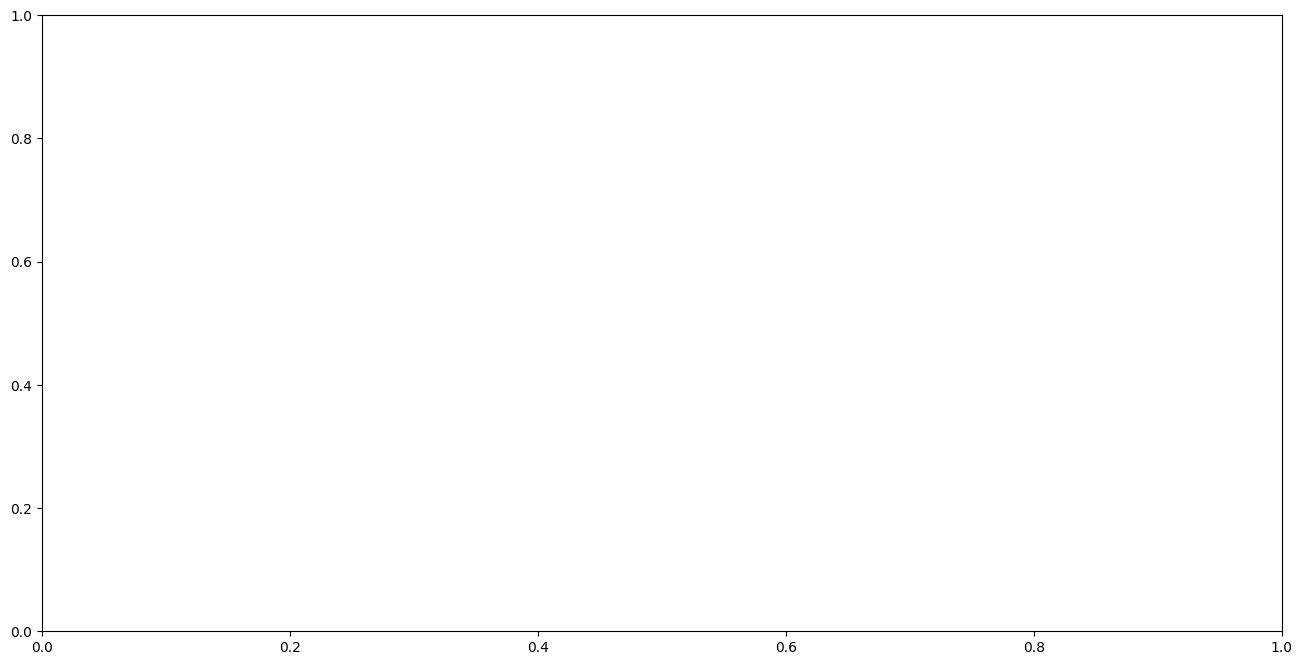

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)